In [1]:
!pip install -q tf-models-official==2.4.0

     |████████████████████████████████| 1.1MB 7.6MB/s 
     |████████████████████████████████| 358kB 12.3MB/s 
     |████████████████████████████████| 174kB 21.8MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 645kB 26.7MB/s 
     |████████████████████████████████| 706kB 37.4MB/s 
     |████████████████████████████████| 1.2MB 52.3MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 37.6MB 77kB/s 


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import official

In [3]:
gs_folder_bert = 'gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12'
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [4]:
hub_url_bert = "https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [5]:
glue, info = tfds.load('glue/mrpc', with_info=True, batch_size=-1)

Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteYCEEXB/glue-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteYCEEXB/glue-validation.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/glue/mrpc/1.0.0.incompleteYCEEXB/glue-test.tfrecord
Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='glue',
    version=1.0.0,
    description='GLUE, the General Language Understanding Evaluation benchmark
(https://gluebenchmark.com/) is a collection of resources for training,
evaluating, and analyzing natural language understanding systems.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=52398',
    features=FeaturesDict({
        'idx': tf.int32,
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'sentence1': Text(shape=(), dtype=tf.string),
        'sentence2': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=5801,
    splits={
        'test': 1725,
        'train': 3668,
        'validation': 408,
    },
    supervised_keys=None,
    citation="""@inproceedings{dolan2005automatically,
      title={Automatically constructing a corpus of sentential paraphrases},
      author={Dolan, William B and Brockett, Chris},
      booktitle={Proceedings of the Third International Workshop on Para

In [7]:
list(glue.keys())

['test', 'train', 'validation']

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [9]:
info.features['label'].names

['not_equivalent', 'equivalent']

In [10]:
glue_train = glue['train']

In [11]:
for key, value in glue_train.items():
    print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


In [12]:
import official.nlp.bert.tokenization

In [13]:
tokenizer = official.nlp.bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, 'vocab.txt'), do_lower_case=True)

In [14]:
print('Vocab size: ', len(tokenizer.vocab))

Vocab size:  30522


In [15]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
tokens.append('[SEP]')
print(tokens)

['hello', 'tensor', '##flow', '!']
['hello', 'tensor', '##flow', '!', '[SEP]']


In [16]:
ids = tokenizer.convert_tokens_to_ids(tokens)
ids

[7592, 23435, 12314, 999, 102]

In [17]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [18]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s.numpy()))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [19]:
for s in glue_train['sentence1'][:5]:
    print(encode_sentence(s))

[1996, 7235, 9819, 2097, 2552, 2004, 20478, 21334, 2015, 1010, 6575, 2005, 3350, 1997, 2627, 2300, 1012, 102]
[2625, 2084, 2322, 3867, 1997, 23193, 1005, 1055, 4341, 2052, 2272, 2013, 2437, 13891, 1998, 3259, 2044, 1996, 2436, 17848, 5309, 2003, 2949, 1012, 102]
[6804, 1011, 2158, 14177, 1002, 12457, 1012, 1021, 2454, 1999, 2049, 2834, 2197, 2095, 1998, 2253, 2006, 2000, 5425, 1002, 28203, 1012, 1021, 2454, 1012, 102]
[1996, 2526, 2117, 4284, 3463, 2123, 1005, 1056, 2421, 4481, 2013, 2256, 2814, 2012, 4012, 4502, 4160, 1012, 102]
[9168, 1019, 1012, 1019, 2003, 2800, 3322, 1999, 1996, 2142, 2163, 1998, 2710, 1010, 2005, 1037, 3225, 3976, 1997, 2055, 1002, 2260, 1010, 6352, 1012, 102]


In [20]:
sentence1 = tf.ragged.constant([encode_sentence(s) for s in glue_train['sentence1']])
sentence2 = tf.ragged.constant([encode_sentence(s) for s in glue_train['sentence2']])

In [21]:
print(sentence1.shape)
print(sentence2.shape)

(3668, None)
(3668, None)


In [22]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
cls[:5]

[[101], [101], [101], [101], [101]]

In [23]:
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=1)
for i in range(5):
    print(input_word_ids[i])

tf.Tensor(
[  101  1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575
  2005  3350  1997  2627  2300  1012   102  1996  9819  2552  2004 20478
 21334  2015  1010  3048  2006  2416  7787  1012   102], shape=(33,), dtype=int32)
tf.Tensor(
[  101  2625  2084  2322  3867  1997 23193  1005  1055  4341  2052  2272
  2013  2437 13891  1998  3259  2044  1996  2436 17848  5309  2003  2949
  1012   102  2625  2084  2322  3867  1997 23193  1005  1055  4341  2052
  2272  2013  2437 13891  1998  3259  2044  1996  2436 17848  5309  2003
  3143  1010 10262  2216  5661  4995  1005  1056  2853  1012   102], shape=(59,), dtype=int32)
tf.Tensor(
[  101  6804  1011  2158 14177  1002 12457  1012  1021  2454  1999  2049
  2834  2197  2095  1998  2253  2006  2000  5425  1002 28203  1012  1021
  2454  1012   102  6804  1011  2158  1010  6758 18720  1011  2410  1010
 14177  1002 12457  1012  1021  2454  1999  2049  2034  5353  1998  2253
  2006  2000  2202  1999  1002 28203  1012  1021  2454  101

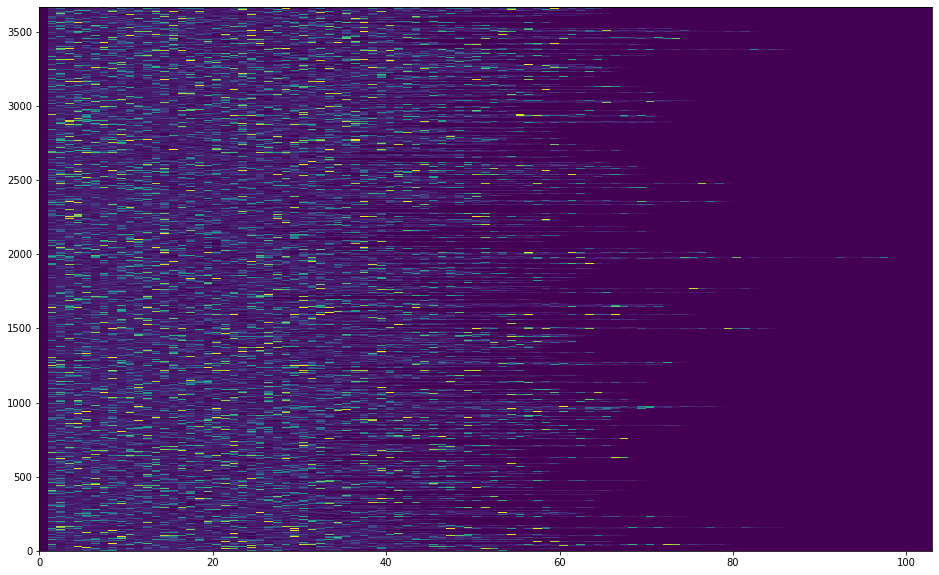

In [24]:
plt.figure(figsize=(16,10))
_ = plt.pcolormesh(input_word_ids.to_tensor())

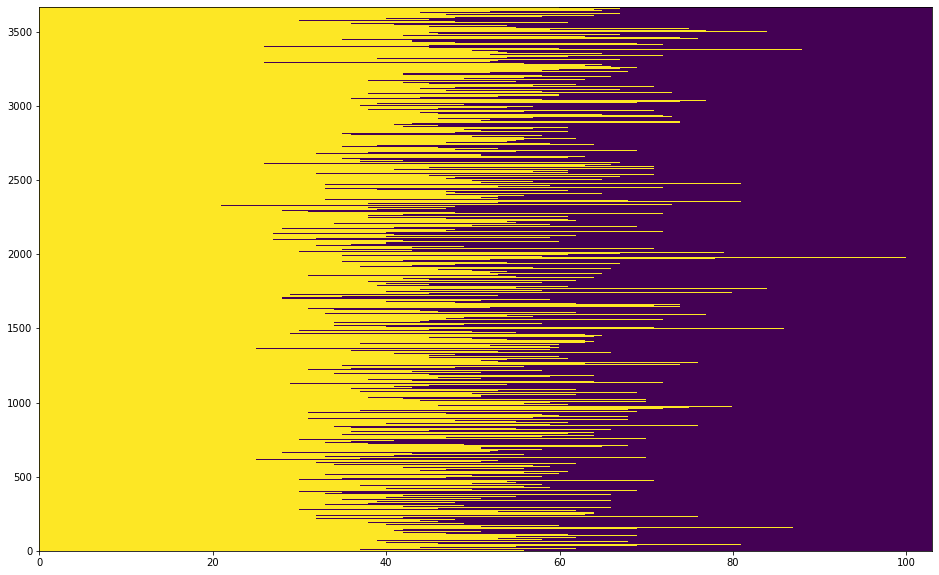

In [25]:
input_mask = tf.ones_like(input_word_ids)
plt.figure(figsize=(16,10))
_ = plt.pcolormesh(input_mask.to_tensor())

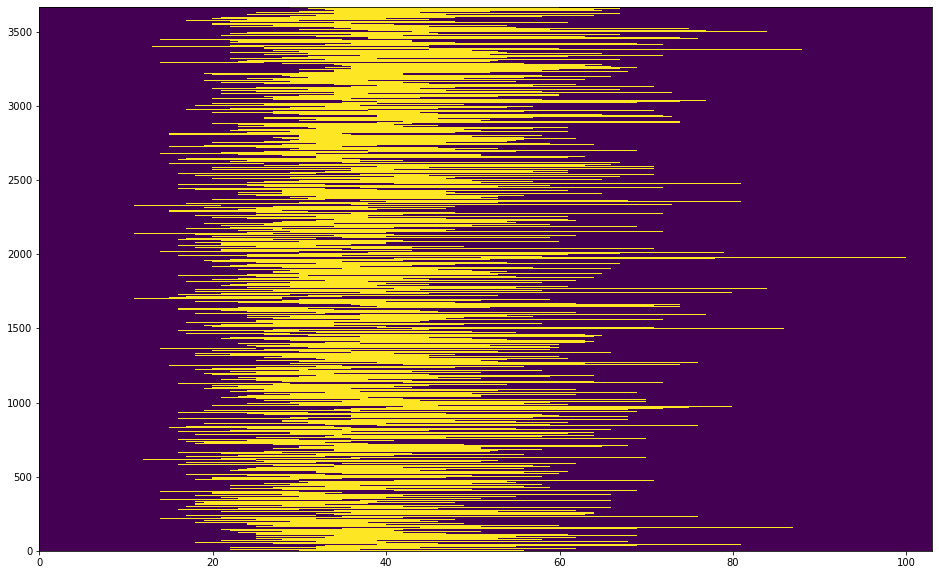

In [26]:
type_cls = tf.zeros_like(cls)
type_sentence1 = tf.zeros_like(sentence1)
type_sentence2 = tf.ones_like(sentence2)

input_type_ids = tf.concat([type_cls, type_sentence1, type_sentence2], axis=1)

plt.figure(figsize=(16,10))
_ = plt.pcolormesh(input_type_ids.to_tensor())

In [27]:
def encode_sentence(s, tokenizer):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
    num_examples = len(glue_dict['sentence1'])

    sentence1 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(glue_dict['sentence1'])])
    sentence2 = tf.ragged.constant([encode_sentence(s, tokenizer) for s in np.array(glue_dict['sentence2'])])
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }

    return inputs

In [28]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test = glue['test']['label']

In [29]:
for key, value in glue_train.items():
    print(f'{key:15s} shape: {value.shape}')

print(f'glue train labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue train labels shape: (3668,)


In [30]:
import json
from official.nlp import bert
import official.nlp.bert.configs

bert_config_file = os.path.join(gs_folder_bert, 'bert_config.json')
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [31]:
import official.nlp.bert.bert_models

bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config, num_labels=2)

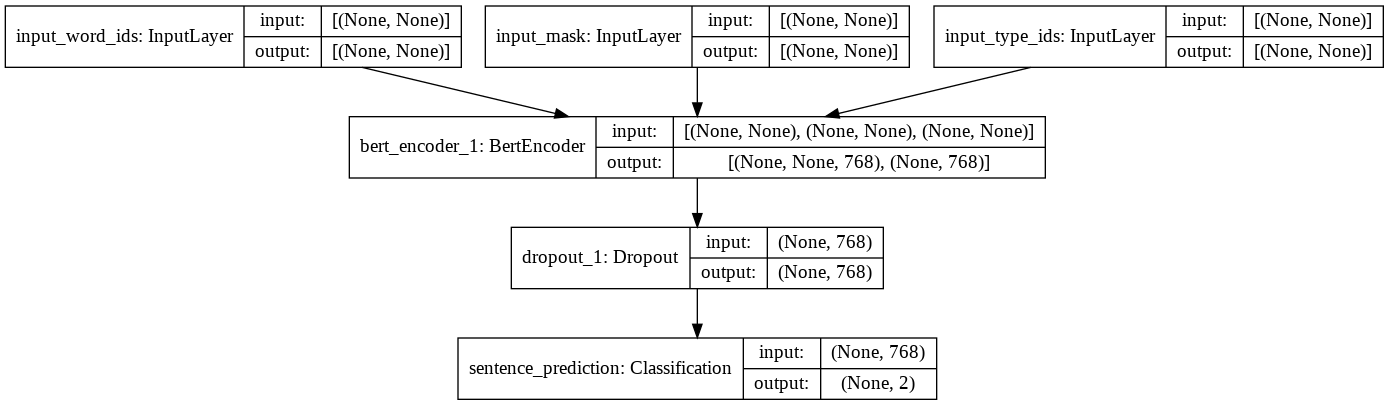

In [32]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True)

In [33]:
glue_batch = {key: value[:10] for key, value in glue_train.items()}

bert_classifier(glue_batch, training=True).numpy()

array([[ 0.09556752, -0.05617733],
       [ 0.0747501 , -0.4362781 ],
       [-0.05881377, -0.386171  ],
       [-0.03390975, -0.05631125],
       [-0.07491447, -0.15526645],
       [-0.07280308, -0.17442209],
       [ 0.0540775 , -0.09058489],
       [ 0.10639006, -0.21508673],
       [ 0.16043177, -0.08973624],
       [-0.19963364, -0.20149073]], dtype=float32)

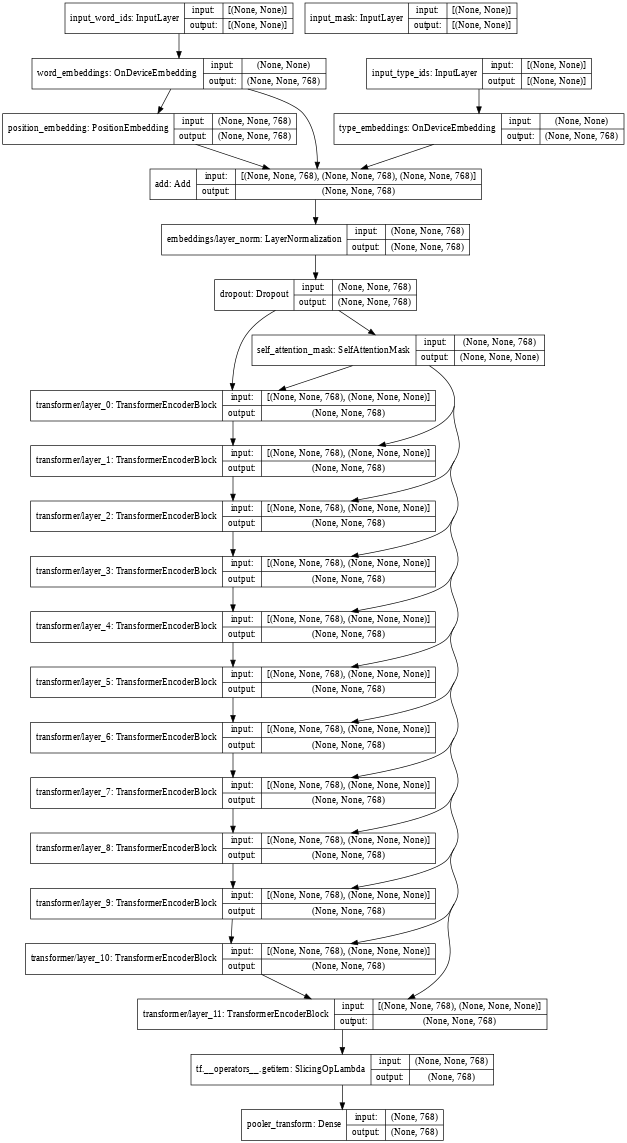

In [34]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [35]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [36]:
from official import nlp
import official.nlp.optimization

epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
warmup_steps = epochs * train_data_size // 10 // batch_size

optimizer = nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [37]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [38]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(True)

bert_classifier.compile(optimizer, loss, metrics)

In [39]:
bert_classifier.fit(glue_train, glue_train_labels, validation_data=(glue_validation, glue_validation_labels), batch_size=32, epochs=epochs)

Epoch 1/3
115/115 [==============================] - 87s 649ms/step - loss: 0.6312 - accuracy: 0.6593 - val_loss: 0.4741 - val_accuracy: 0.7843
Epoch 2/3
115/115 [==============================] - 78s 674ms/step - loss: 0.4417 - accuracy: 0.7947 - val_loss: 0.4294 - val_accuracy: 0.8235
Epoch 3/3
115/115 [==============================] - 78s 677ms/step - loss: 0.3060 - accuracy: 0.8794 - val_loss: 0.4132 - val_accuracy: 0.8456


In [40]:
my_example = bert_encode(
    glue_dict={
        'sentence1': [
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'
        ],
        'sentence2': [
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.'
        ]
    }, tokenizer=tokenizer)

In [41]:
result = bert_classifier(my_example, training=False)
result = tf.argmax(result).numpy()
result

array([1, 0])

In [42]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent'], dtype='<U14')

In [43]:
export_dir = './save_model'

tf.saved_model.save(bert_classifier, export_dir)

INFO:tensorflow:Assets written to: ./save_model/assets


INFO:tensorflow:Assets written to: ./save_model/assets


In [44]:
reloaded = tf.saved_model.load(export_dir)

In [45]:
reloaded_result = reloaded([my_example['input_word_ids'], my_example['input_mask'], my_example['input_type_ids']], training=False)

In [46]:
origin_result = bert_classifier(my_example, training=False)

In [47]:
print(origin_result)
print()
print(reloaded_result)

tf.Tensor(
[[-1.2689451   1.6888434 ]
 [ 1.0068874  -0.39679816]], shape=(2, 2), dtype=float32)

tf.Tensor(
[[-1.268945   1.6888428]
 [ 1.0068873 -0.396798 ]], shape=(2, 2), dtype=float32)


In [48]:
import official.nlp.data.classifier_data_lib
import official.nlp.bert.tokenization

processor = nlp.data.classifier_data_lib.TfdsProcessor(
    tfds_params="dataset=glue/mrpc,text_key=sentence1,text_b_key=sentence2",
    process_text_fn=bert.tokenization.convert_to_unicode
)

In [49]:
train_data_output_path='./mrpc_train.tf_record'
eval_data_output_path='./mrpc_eval.tf_record'

max_seq_length=128
batch_size=32
eval_batch_size=32

input_meta_data=(
    nlp.data.classifier_data_lib.generate_tf_record_from_data_file(
        processor=processor,
        data_dir=None,
        tokenizer=tokenizer,
        train_data_output_path=train_data_output_path,
        eval_data_output_path=eval_data_output_path,
        max_seq_length=max_seq_length
    )
)

In [50]:
import official.nlp.bert.run_classifier

train_dataset = bert.run_classifier.get_dataset_fn(
    train_data_output_path,
    max_seq_length,
    batch_size,
    is_training=True
)()

evaluation_dataset = bert.run_classifier.get_dataset_fn(
    eval_data_output_path,
    max_seq_length,
    batch_size,
    is_training=False
)()

In [51]:
train_dataset

<PrefetchDataset shapes: ({input_word_ids: (32, 128), input_mask: (32, 128), input_type_ids: (32, 128)}, (32,)), types: ({input_word_ids: tf.int32, input_mask: tf.int32, input_type_ids: tf.int32}, tf.int32)>

In [52]:
train_dataset.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [56]:
def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
    dataset = tf.data.TFRecordDataset(file_path)
    if is_training:
        dataset = dataset.shuffle(100)
        dataset = dataset.repeat()
    
    def decode_record(record):
        name_to_features={
            'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
            'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
            'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
            'label_ids': tf.io.FixedLenFeature([], tf.int64),
        }

        return tf.io.parse_single_example(record, name_to_features)
    
    def _select_data_from_record(record):
        x = {
            'input_word_ids': record['input_ids'],
            'input_mask': record['input_mask'],
            'input_type_ids': record['segment_ids'],
        }

        y = record['label_ids']

        return (x, y)
    
    dataset = dataset.map(decode_record, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(_select_data_from_record, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=is_training)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [59]:
print(train_data_output_path)
print(eval_data_output_path)
print(input_meta_data.keys())

./mrpc_train.tf_record
./mrpc_eval.tf_record
dict_keys(['processor_type', 'train_data_size', 'max_seq_length', 'task_type', 'num_labels', 'eval_data_size'])


In [61]:
batch_size=32
eval_batch_size=32

training_dataset=create_classifier_dataset(train_data_output_path, input_meta_data['max_seq_length'], batch_size, is_training=True)
evaluation_dataset=create_classifier_dataset(eval_data_output_path, input_meta_data['max_seq_length'], eval_batch_size, is_training=False)

In [62]:
training_dataset.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

In [63]:
import tensorflow_hub as hub

hub_model_name = "bert_en_uncased_L-12_H-768_A-12"

hub_encoder=hub.KerasLayer(f"https://hub.tensorflow.google.cn/tensorflow/{hub_model_name}/3", True)
print(f"The hub_encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The hub_encoder has 199 trainable variables


In [65]:
result = hub_encoder(
    inputs=dict(
        input_word_ids=glue_train['input_word_ids'][:10],
        input_mask=glue_train['input_mask'][:10],
        input_type_ids=glue_train['input_type_ids'][:10],
    ),
    training=False
)

print(result.keys())

dict_keys(['sequence_output', 'default', 'pooled_output', 'encoder_outputs'])


In [72]:
print(result['pooled_output'].shape)
print(result['sequence_output'].shape)

(10, 768)
(10, 103, 768)


In [76]:
hub_classifier = nlp.modeling.models.BertClassifier(
    bert_encoder,
    num_classes=2,
    dropout_rate=0.1,
    initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)
)

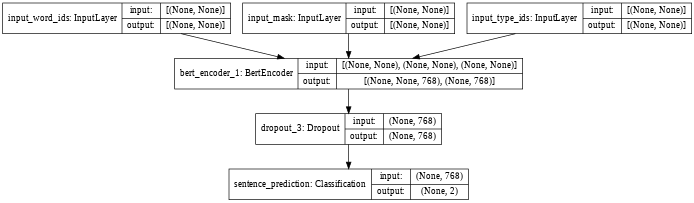

In [77]:
tf.keras.utils.plot_model(hub_classifier, show_shapes=True, dpi=48)

In [79]:
try:
    tf.keras.utils.plot_model(hub_encoder, show_shapes=True, dpi=48)
    assert False
except Exception as e:
    print(f'{type(e).__name__}: {e}')

AttributeError: 'KerasLayer' object has no attribute 'layers'


In [80]:
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [81]:
from official.modeling import tf_utils

bert_encoder_config=config_dict.copy()

bert_encoder_config['attention_dropout_rate']=bert_encoder_config.pop('attention_probs_dropout_prob')
bert_encoder_config['activation']=tf_utils.get_activation(bert_encoder_config.pop('hidden_act'))
bert_encoder_config['dropout_rate']=bert_encoder_config.pop('hidden_dropout_prob')
bert_encoder_config['initializer']=tf.keras.initializers.TruncatedNormal(stddev=bert_encoder_config.pop('initializer_range'))
bert_encoder_config['max_sequence_length']=bert_encoder_config.pop('max_position_embeddings')
bert_encoder_config['num_layers']=bert_encoder_config.pop('num_hidden_layers')

bert_encoder_config

{'activation': <function official.modeling.activations.gelu.gelu>,
 'attention_dropout_rate': 0.1,
 'dropout_rate': 0.1,
 'hidden_size': 768,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7f2a3bd39f50>,
 'intermediate_size': 3072,
 'max_sequence_length': 512,
 'num_attention_heads': 12,
 'num_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [82]:
import official.nlp.modeling.networks

manual_encoder=nlp.modeling.networks.BertEncoder(**bert_encoder_config)

In [ ]:
tf.keras.utils.plot_model(manual_encoder)

In [85]:
checkpoint=tf.train.Checkpoint(encoder=manual_encoder)
checkpoint.read(os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [86]:
my_example

{'input_mask': <tf.Tensor: shape=(2, 23), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(2, 23), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0]], dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(2, 23), dtype=int32, numpy=
 array([[  101,  1996,  4542,  1999,  3577,  4212,  3701,  2006,  1996,
          5810,  1012,   102,  2009,  3262, 15811,  2006,  1996,  4257,
          4915,  1997,  3577,  1012,   102],
        [  101,  2298,  1045,  2986, 15757, 14324,  1012,   102,  2003,
          2009,  2551,  1029,  2023,  2515,  2025,  2674,  1012,   102,
             0,     0,     0,     0,     0]], dtype=int32)>}

In [87]:
result=manual_encoder(my_example, training=True)
print('Sequence output shape {}'.format(result[0].shape))
print('Pooled output shape {}'.format(result[1].shape))

Sequence output shape (2, 23, 768)
Pooled output shape (2, 768)


In [88]:
import official.nlp.modeling.models

manual_classifier=nlp.modeling.models.BertClassifier(
    manual_encoder,
    num_classes=2,
    dropout_rate=bert_encoder_config['dropout_rate'],
    initializer=bert_encoder_config['initializer']
)

In [91]:
manual_classifier(my_example, training=True)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.29449016,  0.4012445 ],
       [-0.12125929, -0.0199383 ]], dtype=float32)>

In [89]:
manual_classifier(my_example, training=True).numpy()

array([[-0.5185471 ,  0.26679876],
       [-0.55542934,  0.03976727]], dtype=float32)

In [92]:
optimizer=nlp.optimization.create_optimizer(2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [93]:
epochs=3
batch_size=32
eval_batch_size=32

train_data_size=len(glue_train_labels)
steps_per_epoch=train_data_size // batch_size
num_train_steps=steps_per_epoch * epochs

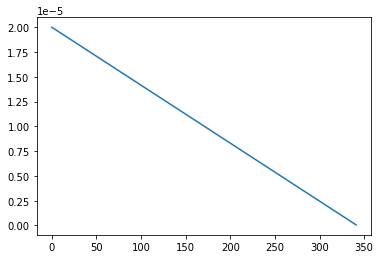

In [97]:
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=2e-5,
    decay_steps=num_train_steps,
    end_learning_rate=0
)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])

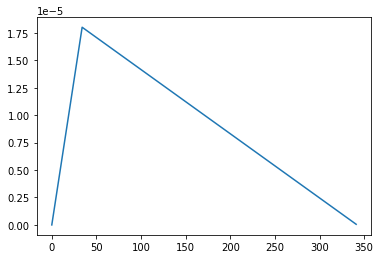

In [99]:
warmup_steps = num_train_steps // 10

warmup_schedule=nlp.optimization.WarmUp(
    initial_learning_rate=decay_schedule(warmup_steps),
    decay_schedule_fn=decay_schedule,
    warmup_steps=warmup_steps
)

plt.plot([warmup_schedule(n) for n in range(num_train_steps)])

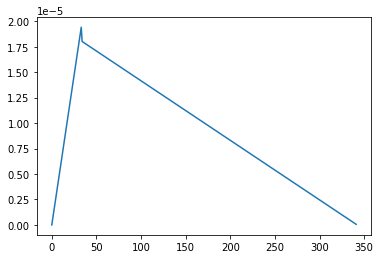

In [98]:
warmup_steps = num_train_steps // 10

warmup_schedule=nlp.optimization.WarmUp(
    initial_learning_rate=2e-5,
    decay_schedule_fn=decay_schedule,
    warmup_steps=warmup_steps
)

plt.plot([warmup_schedule(n) for n in range(num_train_steps)])

In [102]:
optimizer=nlp.optimization.AdamWeightDecay(
    learning_rate=warmup_schedule,
    weight_decay_rate=0.01,
    epsilon=1e-6,
    exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias']
)

In [103]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(True)

manual_classifier.compile(optimizer, loss, metrics)

In [104]:
history=manual_classifier.fit(x=glue_train, y=glue_train_labels, validation_data=(glue_validation, glue_validation_labels), epochs=epochs)

Epoch 1/3
115/115 [==============================] - 95s 714ms/step - loss: 0.6159 - accuracy: 0.6901 - val_loss: 0.4819 - val_accuracy: 0.7990
Epoch 2/3
115/115 [==============================] - 83s 724ms/step - loss: 0.4209 - accuracy: 0.8204 - val_loss: 0.3673 - val_accuracy: 0.8333
Epoch 3/3
115/115 [==============================] - 83s 726ms/step - loss: 0.2842 - accuracy: 0.8976 - val_loss: 0.3633 - val_accuracy: 0.8456


In [105]:
result = bert_classifier(my_example, training=False)
result = tf.argmax(result).numpy()
result

array([1, 0])